In [1]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
transform3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize first (required for some augmentations)
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),  # Spatial augmentations
    transforms.ColorJitter(hue=0.05, saturation=0.05),  # Color augmentations
    transforms.RandomHorizontalFlip(),  # Flip augmentation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),  # Optional blur
    transforms.ToTensor(),  # Convert to tensor (normalized to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet stats
])

In [3]:
dataset_resnet=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform3)

In [4]:
indices=list(range(len(dataset_resnet))) # dataset ko numerate karne ke liye
split=int(np.floor(0.70*len(dataset_resnet)))
validation=int(np.floor(0.60*split))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%

print(f"length of train size : {validation}")
print(f"length of validation size : {split-validation}")
print(f"length of test size : {len(dataset_resnet)-split}")

np.random.shuffle(indices) # dataset me randomness laane ke liye

# ab actual splitting
train_indices, validation_indices, test_indices = (
    indices[:validation], # [:5]->0,1,2,3,4
    indices[validation:split],# [1:3]->1,2
    indices[split:],# [2:]-> 2,3,4,5,........
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


length of train size : 1585
length of validation size : 1058
length of test size : 1134


In [5]:
targets_size = len(dataset_resnet.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_resnet.class_to_idx.keys()))
num_classes_list = list(dataset_resnet.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

In [6]:
model = models.resnet18(pretrained=True)
# model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
n_features = model.conv1.in_channels #resnet18; number of input features in the first convolutional layer
n_features

3

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
# calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy
optimizer = torch.optim.Adam(model.parameters())
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

In [10]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=validation_sampler
)

In [ ]:
train_losses_resnet = batch_gd(model, criterion, train_loader, validation_loader, 10)

In [11]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Training and Validation Losses', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [12]:
def batch_gd_new(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # Memory tracking initialization
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        mem_before = torch.cuda.memory_allocated() / 1024**2  # MB
    
    # Track average inference time
    total_inference_time = 0
    inference_count = 0
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.time()
            optimizer.zero_grad()
            output = model(inputs)
            inference_time = time.time() - start_time
            
            total_inference_time += inference_time
            inference_count += 1
            
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        test_loss = []
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                test_loss.append(loss.item())
        model.train()

        test_loss = np.mean(test_loss)
        train_losses[e] = train_loss
        test_losses[e] = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {e+1}/{epochs} Train loss: {train_loss:.4f} Val loss: {test_loss:.4f} Duration: {dt}")

    # Memory and timing results
    avg_inference_time = total_inference_time / inference_count if inference_count > 0 else 0
    print(f"\nTraining Summary:")
    print(f"Average inference time per batch: {avg_inference_time:.4f} seconds")
    
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1024**2
        mem_used = mem_after - mem_before
        print(f"GPU Memory used: {mem_used:.2f} MB")
    
    return train_losses, test_losses

Epoch 1/10 Train loss: 4.7543 Val loss: 3.9972 Duration: 0:01:19.696239
Epoch 2/10 Train loss: 1.4451 Val loss: 1.7920 Duration: 0:01:12.029992
Epoch 3/10 Train loss: 0.5337 Val loss: 0.7137 Duration: 0:01:11.604951
Epoch 4/10 Train loss: 0.2799 Val loss: 0.4538 Duration: 0:01:11.972267
Epoch 5/10 Train loss: 0.1740 Val loss: 0.4574 Duration: 0:01:11.588810
Epoch 6/10 Train loss: 0.1487 Val loss: 0.4392 Duration: 0:01:11.493746
Epoch 7/10 Train loss: 0.1729 Val loss: 0.5592 Duration: 0:01:11.232846
Epoch 8/10 Train loss: 0.1206 Val loss: 0.3204 Duration: 0:01:11.510821
Epoch 9/10 Train loss: 0.0718 Val loss: 0.2550 Duration: 0:01:11.784172
Epoch 10/10 Train loss: 0.0651 Val loss: 0.3576 Duration: 0:01:11.788347

Training Summary:
Average inference time per batch: 0.0049 seconds
GPU Memory used: 35.19 MB


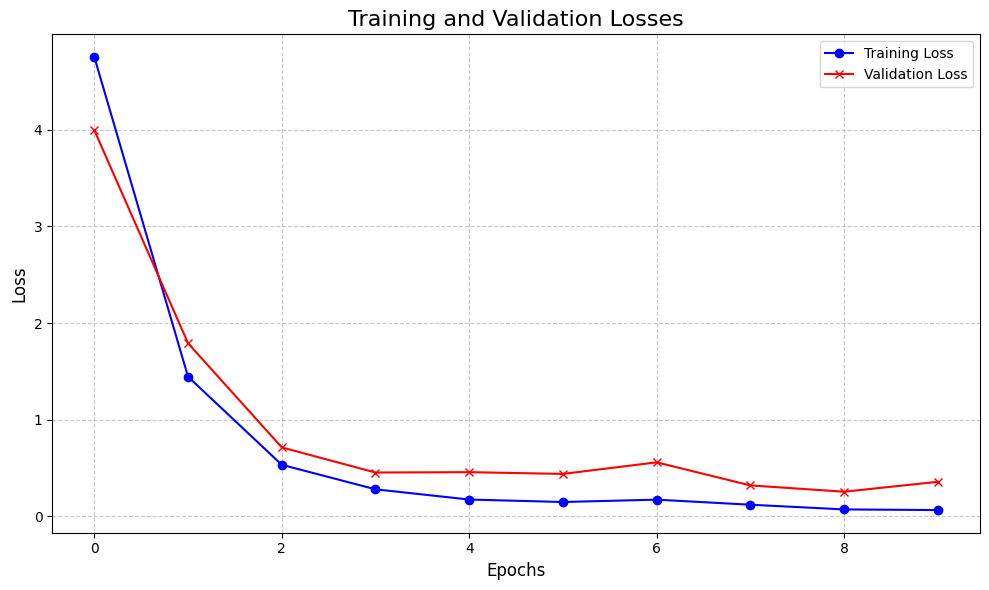

In [16]:
train_losses, test_losses= batch_gd_new(model, criterion, train_loader, validation_loader, 10)
plot_losses(train_losses, test_losses)

In [ ]:
plt.plot(train_losses_resnet , label = 'train_loss_vgg')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()#validation loss ke liye 

In [21]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        # print(outputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [22]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9848580441640379
Test Accuracy : 0.9126984126984127
Validation Accuracy : 0.9234404536862004
